# Tavoitteena on rakentaa luokittelumalli, joka ennustaa asiakaspäätöksen tiettyyn markkinointikampanjaan, joka perustuu asiakasinformaatioon kuten sukupuoli, ikä ja tulot. 

In [1]:
# Tarkoituksena on mallintaa dataa logistisella regressiolla ja SVM-mallilla.
# Tarkoituksena on lisäksi visualisoida ja arvioida malleja sekä tuoda esiin vaihtoehtoisia malleja.
# Kuinka tuoda dataa ja pilkkoa se analysoivaksi 
# Kuinka visualisoida dataa
# kuinka muokata dataa SMOTE-analyysiä varten
# Kuinka opettaa SVM-mallinnusta ja logistisia regression malleja 
# Kuinka arvioida mallien suorituskykyä confusion matrixin, AUC ja ROC mallien avulla, Gainin ja Liftin taulukoilla
# Kuinka vertailla malleja käyttämällä odotettua arvon viitekehystä

In [2]:
# Kirjastojen tuonti
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split #Data split function
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

In [3]:
# Tuodaan data
data = pd.read_csv('CustomerResponseData.csv')
data.head(10).style #add .style to show all columns (otherwise some columns will be hidden with "...")

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,,0,,,1,19,0,0,Ravensville,19,M,0,0,0,64,13362,S,2,-4,0,1,1,1,0,9,26,0.000000,3
1,13,2,0,,0,,,2,44,12,0,Catburg,44,M,0,0,0,65,13453,S,2,17,24,0,0,0,0,14,19,0.000000,1
2,15,2,0,,0,,,3,45,12,75,Ravensville,45,F,0,0,0,65,13453,U,2,33,36,0,4,2,1,14,19,7.602330,1
3,16,2,1,7/5/2006 0:00:00,0,,183,761,43,12,161,Catburg,43,F,0,0,0,65,13453,U,2,34,36,0,0,3,2,14,19,10.143000,1
4,23,2,0,,0,,,4,42,11,0,Kingsville,42,F,0,0,0,65,13453,M,2,22,24,0,0,0,0,14,19,0.000000,3
5,24,2,0,,0,,,5,39,7,521,Princeton,39,F,0,0,0,65,13453,S,2,26,36,0,0,0,3,14,19,9.854320,2
6,30,2,0,,0,,,6,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0.000000,1
7,30,3,0,,0,,,7,23,0,0,Princeton,23,F,0,0,0,65,13453,S,2,30,36,0,1,0,0,14,19,0.000000,1
8,33,2,0,,0,,,8,24,0,0,Foxton,24,M,0,0,0,65,13453,S,2,-2,0,0,0,0,0,14,19,0.000000,1
9,42,3,0,,0,,,9,35,8,0,Queensbury,35,M,0,0,0,65,13453,M,2,22,24,0,1,0,0,14,19,0.000000,3


In [4]:
data.shape

(21927, 31)

In [5]:
# Valitaan avainmuuttujaksi se, että onko asiakas tehnyt ostopäätöksen vai ei (0 = "no", 1 = "yes). Datassa on neljä erilaista kampanjaa.
keys, counts = np.unique(data.campaign, return_counts=True)
for k, c in zip(keys, counts): 
    print("campaign: " + str(k) + " count: " + str(c))

campaign: 1 count: 1747
campaign: 2 count: 13504
campaign: 3 count: 5285
campaign: 4 count: 1391


In [6]:
# Valitaan kampanjan 2 data.
data2 = data[data['campaign']==2]
data2.shape #we plot the shape (rows, columns) and notice that the row count is correct.

(13504, 31)

In [7]:
# Tarkistetaan puuttuvat arvot
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     13504 non-null  int64  
 1   campaign                        13504 non-null  int64  
 2   response                        13504 non-null  int64  
 3   response_date                   13504 non-null  object 
 4   purchase                        13504 non-null  int64  
 5   purchase_date                   13504 non-null  object 
 6   product_id                      13504 non-null  object 
 7   Rowid                           13504 non-null  int64  
 8   age                             13504 non-null  int64  
 9   age_youngest_child              13504 non-null  int64  
 10  average#balance#feed#index      13504 non-null  int64  
 11  branch                          13504 non-null  object 
 12  debt_equity                     

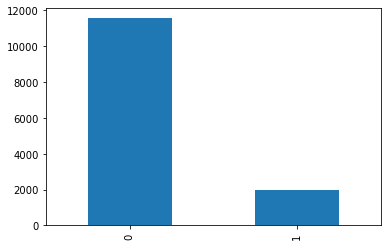

In [8]:
# Valitaan seuraavat muuttujat: sukupuoli, tulot, siviilisääty, rfm_score ja avainmuuttuja (ostopäätös).
# Plotataan avainmuuttuja (ostopäätös).
ax = data2['response'].value_counts().plot(kind='bar')

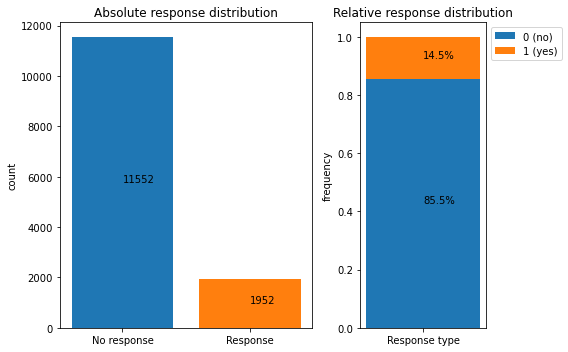

In [9]:
# Plotataan avainmuuttuja (ostopäätös).
# Huomataan, että "no response" on 85.5%.

keys, counts = np.unique(data2.response, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No response', 'Response'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute response distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Response type'], [counts_norm[0]], label='0 (no)')
ax1 = plt.bar(['Response type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (yes)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative response distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

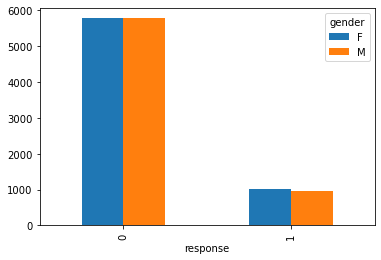

In [10]:
# Plotataan sukupuolen mukaan
ax = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar()

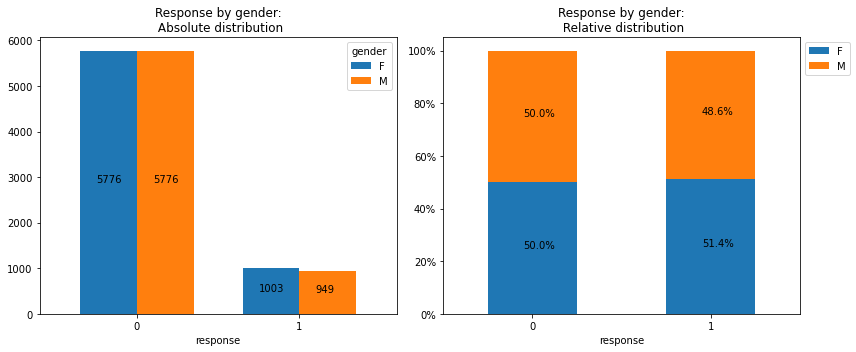

In [11]:
# Plotataan sukupuolen mukaan
# Huomataan tasapuolinen edustus sukupuolten välillä

fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data2.groupby(['response', 'gender'])['gender'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by gender:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data2.groupby(['response','gender'])['gender'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by gender:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

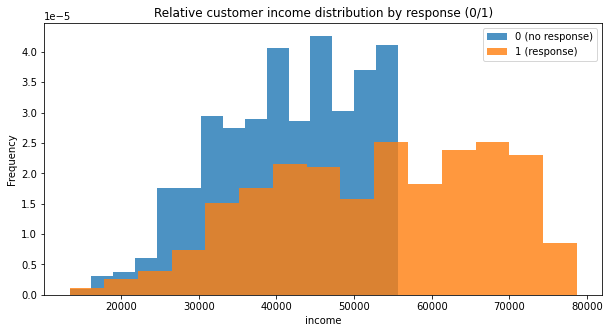

In [12]:
# Plotataan tulojen mukaan
# Huomataan, että tulot alle 55 000 on tasapuolinen edustus sukupuolten välillä
# Kampanja puree erittäin hyvin asiakkaisiin, joiden tulot yli 55 000 

ax = data2['income'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax = data2['income'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax.set_xlabel('income')
ax.set_title('Relative customer income distribution by response (0/1)')
ax.legend();

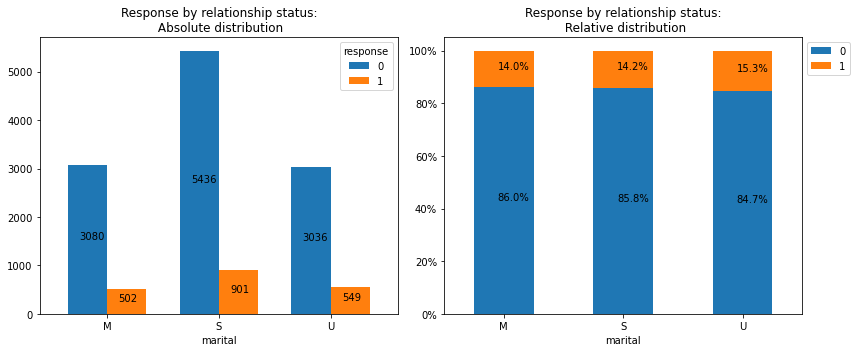

In [13]:
# Plotataan siviilisäädyn mukaan, ei eroja.

fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data2.groupby(['marital', 'response'])['response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by relationship status:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data2.groupby(['marital','response'])['response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Response by relationship status:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

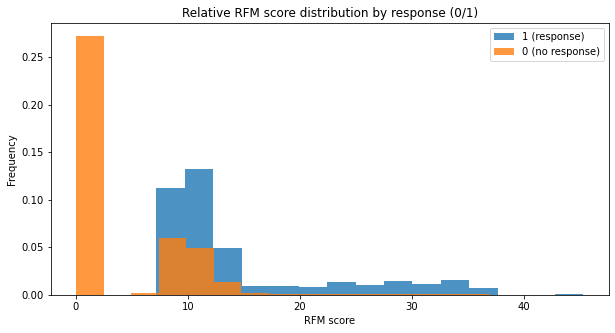

In [14]:
# Plotataan asiakaspäätökset RFM-tuloksen mukaan. RFM arvioi asiakkaan arvoa: kuinka äskettäin ostanut, usein ostaa ja miten paljon ostaa.
# Plotataan RFM score histogrammin muotoon. Matala RFM score ei vastaa kampanjaan, kun taas korkea RFM vastaa kampanjaan.

ax = data2['rfm_score'].loc[data2['response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5))
ax = data2['rfm_score'].loc[data2['response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5))
ax.set_xlabel('RFM score')
ax.set_title('Relative RFM score distribution by response (0/1)')
ax.legend();

In [15]:
# Valitaan muuttujat
X, y = data2[['gender', 'income', 'marital', 'rfm_score']], data2['response'] #define feature matrix X and labels y
X.head()

,gender,income,marital,rfm_score
0,M,13362,S,0.00000
1,M,13453,S,0.00000
2,F,13453,U,7.60233
3,F,13453,U,10.14300
4,F,13453,M,0.00000


In [16]:
# Uudelleenkoodataan kategoriset muuttujat
X = pd.get_dummies(X, columns=["gender", "marital"], prefix=["gender", "marital"]) #we add a prefix for easier identification
X.head()

,income,rfm_score,gender_F,gender_M,marital_M,marital_S,marital_U
0,13362,0.00000,0,1,0,1,0
1,13453,0.00000,0,1,0,1,0
2,13453,7.60233,1,0,0,0,1
3,13453,10.14300,1,0,0,0,1
4,13453,0.00000,1,0,1,0,0


In [17]:
# Splitataan data 70:30 (data_train) (data_test) osuuksiin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) #split data 70:30

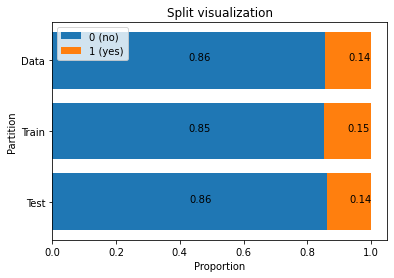

In [18]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

In [19]:
# Uudelleen tasapainotetaan data SMOTE, ainoastaan training data
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train) #ONLY APPLIED TO TRAINING!!!

In [20]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

Original label Counter({0: 8063, 1: 1389})
SMOTE label Counter({0: 8063, 1: 8063})


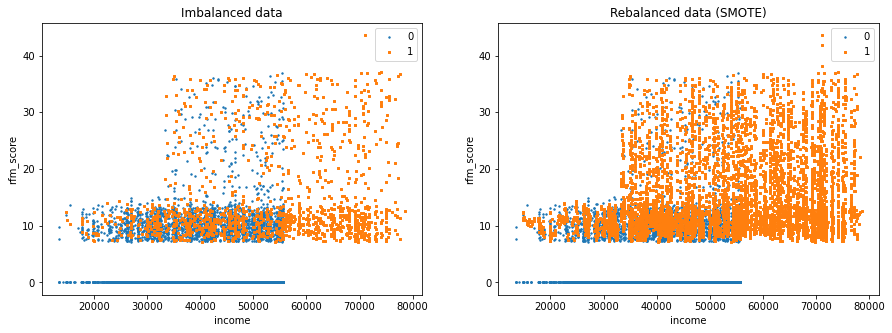

In [21]:
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5)) #specify figure size

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='income', ylabel='rfm_score')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='income', ylabel='rfm_score')

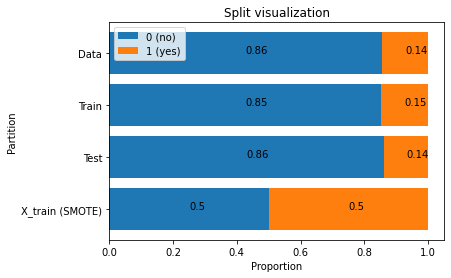

In [22]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

In [23]:
# Model building
svm_imb = SVC(gamma='auto', kernel='rbf') #define SVM classifier 
svm_imb.fit(X_train, y_train) #fit model to (imbalanced) training data

SVC(gamma='auto')

In [24]:
y_pred_svm_imb = svm_imb.predict(X_test)

In [25]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_imb)*100).round(2))

Accuracy is:  86.15


In [26]:
# Balanced data (SMOTE)
svm_bal = SVC(gamma='auto', kernel='rbf') #define SVM classifier 
svm_bal.fit(X_sm, y_sm) #fit SVM model to the SMOTE training data

SVC(gamma='auto')

In [27]:
y_pred_svm_bal = svm_bal.predict(X_test) 

In [28]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_bal)*100).round(2))

Accuracy is:  82.95


In [29]:
svm_bal_proba = SVC(gamma='auto', probability=True)
svm_bal_proba.fit(X_sm, y_sm)

SVC(gamma='auto', probability=True)

In [40]:
y_predProba_svm_bal = svm_bal_proba.predict_proba(X_test)

In [31]:
# Logistic Regression
lr_bal = LogisticRegression(random_state=42, solver='lbfgs') #define Logistic Regression classifier
lr_bal.fit(X_sm, y_sm) #fit LR model to the balanced SMOTE training data

LogisticRegression(random_state=42)

In [32]:
y_pred_lr_bal = lr_bal.predict(X_test)

In [33]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

Accuracy is:  69.64


In [34]:
y_predProba_lr = lr_bal.predict_proba(X_test)

In [35]:
# Model evaluation
# Confusion matrix
# AUC (Area Under the Curve) and ROC curve
# Gains chart
# Lift chart
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

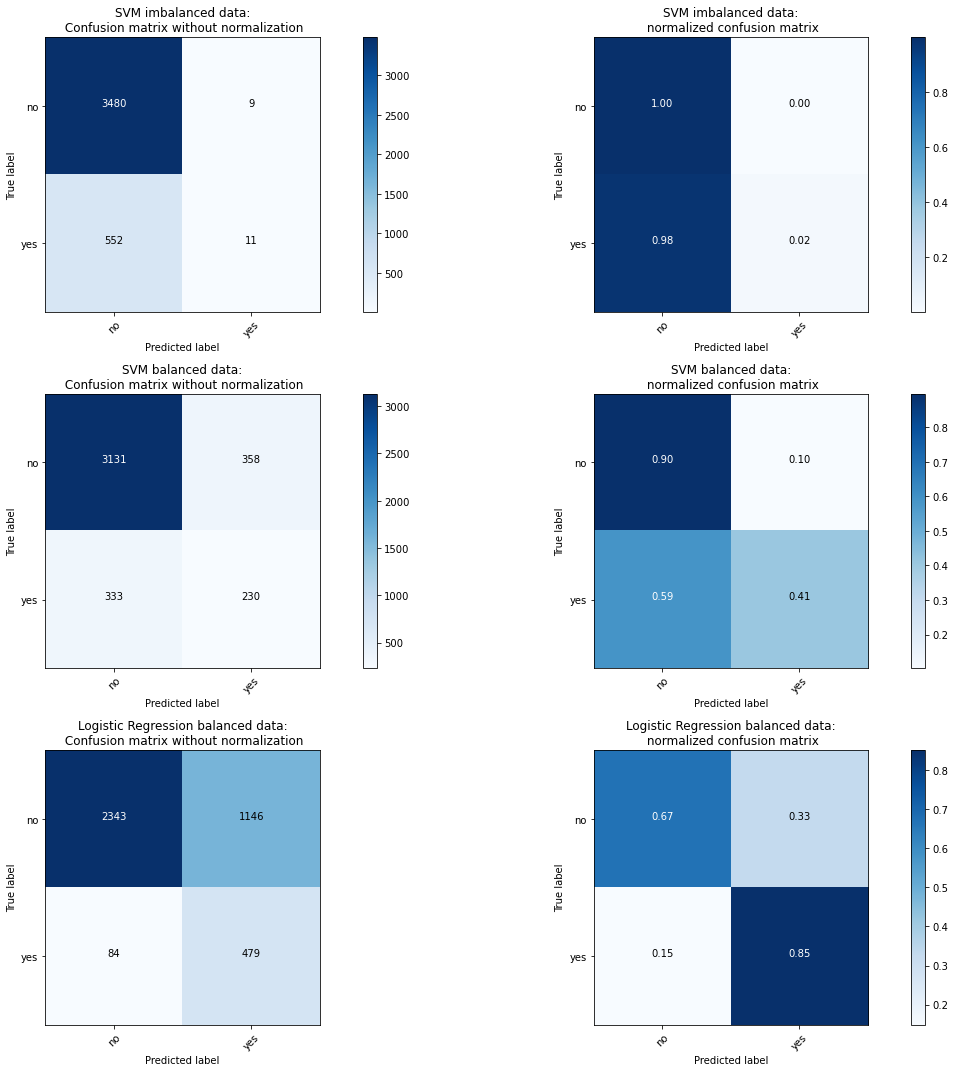

In [36]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_imb = confusion_matrix(y_test, y_pred_svm_imb)
cnf_matrix_bal = confusion_matrix(y_test, y_pred_svm_bal)
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot SVM imbalanced confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_imb, classes=class_names,
                      title='SVM imbalanced data:\n Confusion matrix without normalization')

#Plot SVM imbalanced normalized confusion matrix
plt.subplot(322)
plot_confusion_matrix(cnf_matrix_imb, classes=class_names, normalize=True,
                      title='SVM imbalanced data:\n normalized confusion matrix')

#Plot SVM balanced confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_bal, classes=class_names,
                      title='SVM balanced data:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_bal, classes=class_names, normalize=True,
                      title='SVM balanced data:\n normalized confusion matrix')

#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(325) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(326) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')

plt.show()

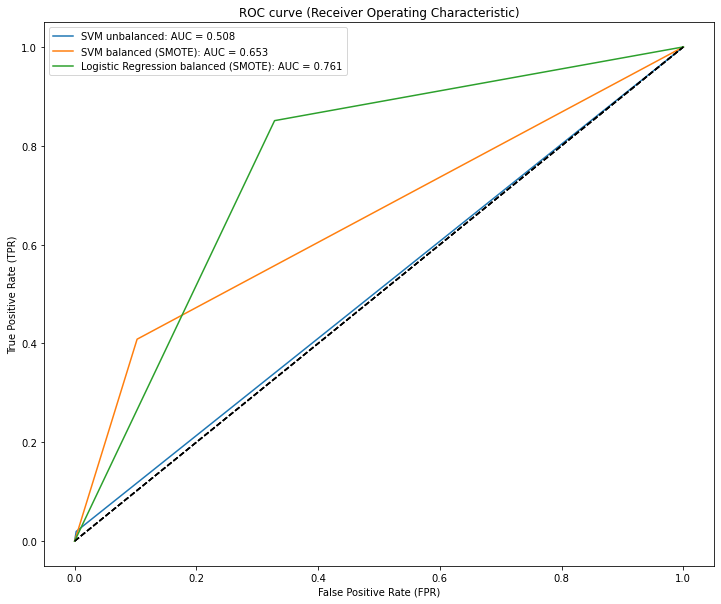

In [37]:
# AUC and ROC
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_svm_imb, y_pred_svm_bal, y_pred_lr_bal], range(1,4), ['SVM unbalanced', 'SVM balanced (SMOTE)', 'Logistic Regression balanced (SMOTE)']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

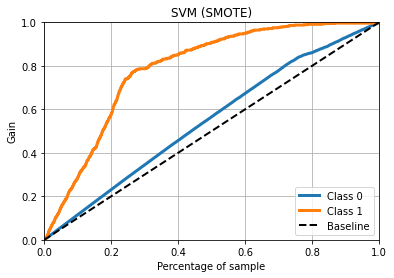

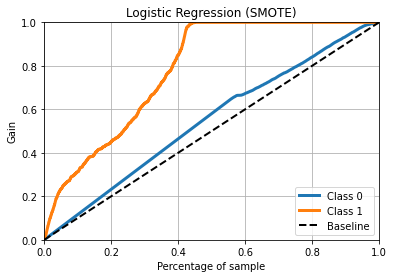

In [38]:
# Cumulative Response Curve, aka. Gains chart
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_bal, title='SVM (SMOTE)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr, title='Logistic Regression (SMOTE)');

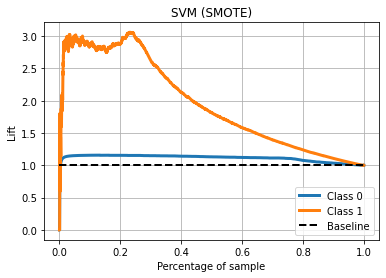

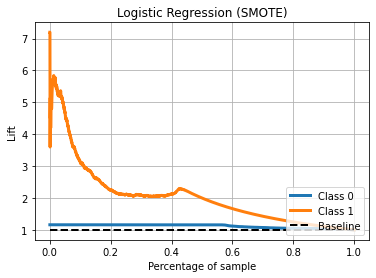

In [39]:
# Lift - How much better is the model compared to a random classifier?
skplt.metrics.plot_lift_curve(y_test, y_predProba_svm_bal, title='SVM (SMOTE)')
skplt.metrics.plot_lift_curve(y_test, y_predProba_lr, title='Logistic Regression (SMOTE)');